
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい


In [110]:
import numpy as np
import pandas as pd

In [111]:
income = pd.read_csv("./Data/income_district.csv")
income["area_code"]=income["area_code"].astype(str)

file_list = ['./Data/h27_age_df.csv', 
             './Data/h27_family_df.csv', 
             './Data/h27_gender_df2.csv', 
             './Data/h27_house_df.csv', 
             './Data/h27_house_info_df.csv',
             './Data/h27_indusry_df.csv', 
             './Data/h27_job_df.csv', 
             './Data/h27_labor_df.csv', 
             './Data/h27_marriage_df.csv', 
             './Data/h27_work_status_df.csv']
for file_csv in file_list:
    df = pd.read_csv(file_csv)
    # level_indentifier is the variable to explain the level of districts.
    # there are 3 levels in level_indentifier, but they do not completely match ku or shi, machi and  chome in Japan.   
    # the variable 'area_code' from income_district.csv is equal to the variable 'district_id' from other csv files.
    # all levels of a district use the same district_id, so the income_mean should match the data whose level_indentifier is 1.
    df = df[df['level_identifier'] == 1] 
    # drop the features which are uncomputable and recurring in csv files
    df.drop(['district2_id','level_identifier','state_name','city_name','district_name','district2_name'], axis=1, inplace=True) 
    df.replace('X', 0, inplace=True)
    df.replace('-', 0, inplace=True)
    df["district_id"]=df["district_id"].astype(str)
    df.rename(columns={'district_id':'area_code'}, inplace=True)
    income=income.merge(df,on='area_code', how='left')

excluded_column = 'area_code'
columns_to_convert = [col for col in income.columns if col != excluded_column]
income[columns_to_convert] = income[columns_to_convert].apply(lambda x: pd.to_numeric(x, errors='coerce').astype(float))


In [112]:
dtypes = income.dtypes
dtype_counts = dtypes.value_counts()
print(dtype_counts)

float64    190
object       1
Name: count, dtype: int64


In [113]:
nan_count = income.isna().sum().sum()
print(f'Total NaN values: {nan_count}')


Total NaN values: 1323


In [114]:
income = income.dropna(subset=['income_mean'])

In [115]:
from sklearn.impute import SimpleImputer

excluded_columns = ['income_mean', 'area_code']

df_to_impute = income.drop(columns=excluded_columns)

imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_to_impute), columns=df_to_impute.columns)

income = pd.concat([df_imputed, income[excluded_columns].reset_index(drop=True)], axis=1)

In [116]:
nan_count = income.isna().sum().sum()
print(f'Total NaN values: {nan_count}')

Total NaN values: 0


In [117]:
income

,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,...,employer_male,self_employed_male,family_work_male,unkonwn_status_male,employer_female,self_employed_female,family_work_female,unkonwn_status_female,income_mean,area_code
0,3913.0,4111.0,3783.0,3563.0,3894.0,4963.0,6498.0,5849.0,4868.0,4470.0,...,16202.0,2501.0,189.0,1224.0,12535.0,640.0,688.0,723.0,480.984419,13228
1,776.0,598.0,387.0,547.0,672.0,788.0,819.0,832.0,882.0,1093.0,...,2713.0,990.0,255.0,2.0,2826.0,277.0,730.0,4.0,439.775281,43514
2,4484.0,4436.0,3874.0,4124.0,4825.0,6093.0,7858.0,6477.0,5171.0,4222.0,...,20262.0,2743.0,212.0,811.0,15647.0,867.0,981.0,446.0,487.507769,23237
3,1211.0,1324.0,1220.0,1328.0,1400.0,1512.0,1863.0,1699.0,1938.0,1980.0,...,6682.0,1141.0,129.0,81.0,6171.0,347.0,523.0,58.0,505.495103,18208
4,1373.0,1493.0,1181.0,1286.0,1691.0,1894.0,2307.0,2218.0,2301.0,2607.0,...,7357.0,1788.0,244.0,129.0,6288.0,410.0,770.0,85.0,385.423846,12238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,8030.0,9088.0,9829.0,8752.0,10205.0,12575.0,15097.0,14522.0,12208.0,9950.0,...,39312.0,3702.0,154.0,1596.0,29655.0,1608.0,782.0,983.0,601.266088,14137
1241,1581.0,1792.0,1334.0,1423.0,1773.0,2068.0,2140.0,2122.0,2288.0,2415.0,...,6709.0,1850.0,412.0,154.0,6613.0,526.0,1167.0,121.0,379.073909,2204
1242,1863.0,1734.0,1502.0,1930.0,2003.0,2452.0,3058.0,2513.0,2459.0,2488.0,...,10119.0,1197.0,164.0,35.0,8345.0,410.0,512.0,29.0,531.328234,16207
1243,8249.0,8803.0,12051.0,19014.0,21610.0,21210.0,22482.0,19609.0,16368.0,13697.0,...,53425.0,7313.0,551.0,6690.0,44983.0,2647.0,2255.0,4460.0,512.674825,13107


In [118]:
percent = income.copy()
cols_to_normalize = percent.columns[:-2]
percent[cols_to_normalize] = percent[cols_to_normalize].div(percent[cols_to_normalize].sum(axis=1), axis=0) * 100

In [119]:
percent

,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,...,employer_male,self_employed_male,family_work_male,unkonwn_status_male,employer_female,self_employed_female,family_work_female,unkonwn_status_female,income_mean,area_code
0,0.359580,0.377775,0.347634,0.327418,0.357834,0.456069,0.597126,0.537487,0.447339,0.410765,...,1.488863,0.229826,0.017368,0.112478,1.151888,0.058812,0.063223,0.066439,480.984419,13228
1,0.372188,0.286815,0.185614,0.262354,0.322307,0.377943,0.392811,0.399047,0.423028,0.524228,...,1.301218,0.474827,0.122304,0.000959,1.355415,0.132856,0.350125,0.001918,439.775281,43514
2,0.373336,0.369339,0.322547,0.343362,0.401727,0.507300,0.654253,0.539272,0.430535,0.351522,...,1.687004,0.228381,0.017651,0.067523,1.302762,0.072186,0.081678,0.037134,487.507769,23237
3,0.311086,0.340114,0.313398,0.341142,0.359637,0.388408,0.478575,0.436446,0.497841,0.508630,...,1.716498,0.293104,0.033138,0.020808,1.585230,0.089139,0.134350,0.014899,505.495103,18208
4,0.260715,0.283502,0.224257,0.244195,0.321100,0.359647,0.438070,0.421170,0.436931,0.495036,...,1.397001,0.339519,0.046333,0.024495,1.194012,0.077854,0.146213,0.016140,385.423846,12238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,0.321005,0.363300,0.392922,0.349868,0.407952,0.502695,0.603514,0.580528,0.488024,0.397759,...,1.571526,0.147990,0.006156,0.063801,1.185481,0.064281,0.031261,0.039296,601.266088,14137
1241,0.339119,0.384378,0.286138,0.305229,0.380302,0.443579,0.459023,0.455162,0.490768,0.518009,...,1.439057,0.396819,0.088373,0.033032,1.418466,0.112825,0.250317,0.025954,379.073909,2204
1242,0.335126,0.311920,0.270187,0.347178,0.360309,0.441078,0.550088,0.452051,0.442337,0.447554,...,1.820255,0.215322,0.029501,0.006296,1.501140,0.073753,0.092101,0.005217,531.328234,16207
1243,0.211052,0.225227,0.308327,0.486477,0.552896,0.542662,0.575207,0.501700,0.418779,0.350441,...,1.366890,0.187105,0.014097,0.171165,1.150900,0.067724,0.057695,0.114110,512.674825,13107


In [124]:
from sklearn.model_selection import train_test_split

# SPLIT DATA
X, y = percent.drop(columns=['area_code','income_mean']), income['income_mean']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [125]:
from sklearn.metrics       import root_mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso, Ridge

# CREATE THE MODEL
lr_lasso = Lasso()
# FIT THE MODEL
lr_lasso.fit(X_train, y_train)
# EVALUATE THE MODEL
y_lasso_pred= lr_lasso.predict(X_test)
print(f"LASSO RMSE: {root_mean_squared_error(y_test, y_lasso_pred)}")


LASSO RMSE: 35.477260559698685


In [128]:
# LINEAR REGRESSION
from sklearn.linear_model    import LinearRegression, Lasso, Ridge
from sklearn.metrics       import root_mean_squared_error
from sklearn.preprocessing   import OneHotEncoder, StandardScaler

# STANDARDIZE NUMERICAL COLUMNS
scaler = StandardScaler()
float_cols = X_train.select_dtypes(include=['float64']).columns
X_train[float_cols] = scaler.fit_transform(X_train[float_cols])
X_test[float_cols] = scaler.transform(X_test[float_cols])

# CREATE THE MODEL
lr = LinearRegression()
# FIT THE MODEL
lr.fit(X_train, y_train)
# PREDICT THE TEST DATA
y_lr_pred = lr.predict(X_test)
# EVALUATE THE MODEL
print(f"LINEAR RMSE: {root_mean_squared_error(y_test, y_lr_pred)}")

# CREATE THE MODEL
lr_lasso = Lasso()
# FIT THE MODEL
lr_lasso.fit(X_train, y_train)
# EVALUATE THE MODEL
y_lasso_pred= lr_lasso.predict(X_test)
print(f"LASSO RMSE: {root_mean_squared_error(y_test, y_lasso_pred)}")

# CREATE THE MODEL
lr_ridge = Ridge()
# FIT THE MODEL
lr_ridge.fit(X_train, y_train)
# PREDICT THE TEST DATA
y_ridge_pred = lr_ridge.predict(X_test)
# EVALUATE THE MODEL
print(f"RIDGE RMSE: {root_mean_squared_error(y_test, y_ridge_pred)}")

LINEAR RMSE: 19.797050012236507
LASSO RMSE: 23.080557389624815
RIDGE RMSE: 19.27101894053714


这里出了个操作上的问题，我把均一化后的数据油标准化了，但是效果蛮不错的额……

<Axes: xlabel='income_mean'>

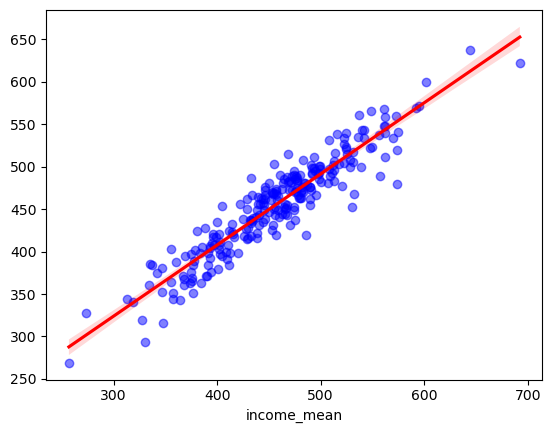

In [129]:
import seaborn as sns

sns.regplot(x = y_test, y = y_lasso_pred,
            scatter_kws = {"color": "blue", "alpha": 0.5},
            line_kws = {"color": "red"})

In [141]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nn_simple = Sequential()
nn_simple.add(Dense(128, input_dim=189, activation='relu'))
nn_simple.add(Dense(128, activation='relu'))
nn_simple.add(Dense(64, activation='relu'))
nn_simple.add(Dense(32, activation='relu'))
nn_simple.add(Dense(16, activation='relu'))
nn_simple.add(Dense(1))


nn_simple.compile(optimizer='adam', loss='mean_squared_error')
history = nn_simple.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
y_nn_pred = nn_simple.predict(X_test)
print(f"Neural Network RMSE: {root_mean_squared_error(y_test, y_nn_pred)}")

Epoch 1/100
25/25 [==============================] - 3s 14ms/step - loss: 196085.4688 - val_loss: 178040.9531
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 93047.0625 - val_loss: 33906.2461
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 26685.8574 - val_loss: 21585.7480
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 16672.0215 - val_loss: 15114.8887
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 11662.4043 - val_loss: 11444.7783
Epoch 6/100
25/25 [==============================] - 0s 6ms/step - loss: 8962.0801 - val_loss: 9348.1553
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 7233.4087 - val_loss: 7917.0942
Epoch 8/100
25/25 [==============================] - 0s 9ms/step - loss: 6010.7197 - val_loss: 7490.3164
Epoch 9/100
25/25 [==============================] - 0s 6ms/step - loss: 5182.9399 - val_loss: 6531.1226
Epoch 10/100
25/25 [======================

<Axes: xlabel='income_mean'>

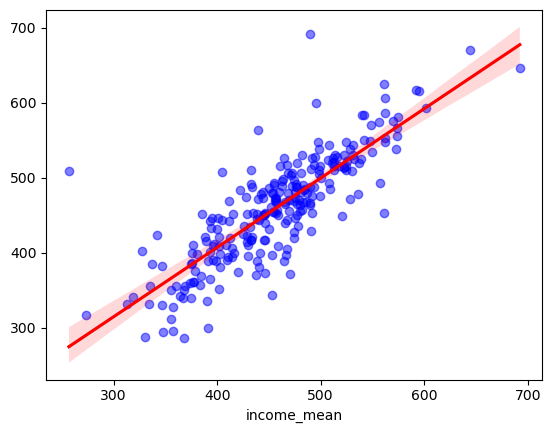

In [142]:
sns.regplot(x = y_test, y = y_nn_pred,
            scatter_kws = {"color": "blue", "alpha": 0.5},
            line_kws = {"color": "red"})

In [165]:
income_l2 = pd.DataFrame()
for file_csv in file_list:
    df = pd.read_csv(file_csv)
    df = df[df['level_identifier'] == 2] 
    df['district_id'] = df['district_id'].astype(str)
    df['district2_id'] = df['district2_id'].astype(str)
    df['district_id_l2'] = df['district_id']+'-'+df['district2_id']
    df.rename(columns={'district_id':'area_code'}, inplace=True)
    df.drop(['district2_id','level_identifier','state_name','city_name','district_name','district2_name'], axis=1, inplace=True) 
    df.replace('X', 0, inplace=True)
    df.replace('-', 0, inplace=True)

    if income_l2.empty:
        income_l2 = df
    else:
        income_l2 = income_l2.merge(df, on=['district_id_l2', 'area_code'], how='left')



In [166]:
excluded_columns = ['district_id_l2', 'area_code']

df_to_impute = income_l2.drop(columns=excluded_columns)

imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_to_impute), columns=df_to_impute.columns)

income_l2 = pd.concat([df_imputed, income_l2[excluded_columns].reset_index(drop=True)], axis=1)

In [178]:
nan_count_l2 = income_l2.isna().sum().sum()
print(f'Total NaN values: {nan_count_l2}')

Total NaN values: 0


In [168]:
income_l2

,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,...,employer_male,self_employed_male,family_work_male,unkonwn_status_male,employer_female,self_employed_female,family_work_female,unkonwn_status_female,district_id_l2,area_code
0,32.0,56.0,61.0,60.0,64.0,74.0,99.0,94.0,74.0,67.0,...,198.0,42.0,9.0,24.0,206.0,36.0,17.0,20.0,45201-10.0,45201
1,60.0,114.0,148.0,133.0,123.0,146.0,210.0,178.0,143.0,109.0,...,439.0,78.0,2.0,30.0,443.0,49.0,37.0,27.0,45201-20.0,45201
2,23.0,39.0,56.0,80.0,89.0,93.0,91.0,76.0,72.0,69.0,...,261.0,41.0,5.0,15.0,212.0,23.0,19.0,14.0,45201-30.0,45201
3,12.0,37.0,65.0,73.0,46.0,62.0,54.0,61.0,57.0,61.0,...,169.0,31.0,3.0,20.0,176.0,20.0,13.0,12.0,45201-40.0,45201
4,0.0,1.0,1.0,3.0,1.0,1.0,0.0,1.0,1.0,2.0,...,4.0,2.0,0.0,0.0,7.0,3.0,1.0,0.0,45201-50.0,45201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102597,11.0,3.0,4.0,8.0,9.0,10.0,10.0,11.0,10.0,25.0,...,38.0,15.0,0.0,4.0,39.0,1.0,10.0,3.0,8564-190.0,8564
102598,8.0,9.0,7.0,8.0,11.0,10.0,9.0,16.0,9.0,20.0,...,55.0,12.0,0.0,0.0,43.0,2.0,5.0,1.0,8564-200.0,8564
102599,15.0,14.0,13.0,12.0,13.0,14.0,15.0,16.0,36.0,33.0,...,78.0,22.0,4.0,3.0,67.0,5.0,7.0,1.0,8564-210.0,8564
102600,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,...,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,8564-220.0,8564


In [169]:
# excluded_columns = ['district_id_l2','area_code']
# columns_to_convert = [col for col in income_l2.columns if col not in excluded_columns]
# income_l2[columns_to_convert] = income_l2[columns_to_convert].apply(lambda x: pd.to_numeric(x, errors='coerce').astype(float))

In [170]:
dtypes_l2 = income_l2.dtypes
dtype_counts_l2 = dtypes_l2.value_counts()
print(dtype_counts_l2)

float64    189
object       2
Name: count, dtype: int64


In [183]:
percent_l2 = income_l2.copy()
nan_count_pl2 = percent_l2.isna().sum().sum()
print(f'1 Total NaN values: {nan_count_pl2}')

cols_to_normalize = percent_l2.columns[:-2]
percent_l2[cols_to_normalize] = percent_l2[cols_to_normalize].div(percent_l2[cols_to_normalize].sum(axis=1), axis=0) * 100

X_l2 = percent_l2[cols_to_normalize]

imputer = SimpleImputer(strategy='mean')
X_l2 = pd.DataFrame(imputer.fit_transform(X_l2), columns=X_l2.columns)

nan_count_pl2 = X_l2.isna().sum().sum()
print(f'X_l2 Total NaN values: {nan_count_pl2}')


1 Total NaN values: 0
X_l2 Total NaN values: 0


In [184]:
# STANDARDIZE NUMERICAL COLUMNS
scaler = StandardScaler()
float_cols = X_l2.select_dtypes(include=['float64']).columns
X_l2 = scaler.fit_transform(X_l2)

# PREDICT THE TEST DATA
y_l2_pred = lr_ridge.predict(X_l2)

/opt/anaconda3/envs/chss/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [185]:
income_l3 = pd.DataFrame()
for file_csv in file_list:
    df = pd.read_csv(file_csv)
    df = df[df['level_identifier'] == 3] 
    df['district_id'] = df['district_id'].astype(str)
    df['district2_id'] = df['district2_id'].astype(str)
    df['district_id_l3'] = df['district_id']+'-'+df['district2_id']
    df.rename(columns={'district_id':'area_code'}, inplace=True)
    df.drop(['district2_id','level_identifier','state_name','city_name','district_name','district2_name'], axis=1, inplace=True) 
    df.replace('X', 0, inplace=True)
    df.replace('-', 0, inplace=True)

    if income_l3.empty:
        income_l3 = df
    else:
        income_l3 = income_l3.merge(df, on=['district_id_l3', 'area_code'], how='left')

excluded_columns = ['district_id_l3', 'area_code']

df_to_impute = income_l3.drop(columns=excluded_columns)

imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_to_impute), columns=df_to_impute.columns)

income_l3 = pd.concat([df_imputed, income_l3[excluded_columns].reset_index(drop=True)], axis=1)

percent_l3 = income_l3.copy()
nan_count_pl3 = percent_l3.isna().sum().sum()
print(f'1 Total NaN values: {nan_count_pl3}')

cols_to_normalize = percent_l3.columns[:-2]
percent_l3[cols_to_normalize] = percent_l3[cols_to_normalize].div(percent_l3[cols_to_normalize].sum(axis=1), axis=0) * 100

X_l3 = percent_l3[cols_to_normalize]

imputer = SimpleImputer(strategy='mean')
X_l3 = pd.DataFrame(imputer.fit_transform(X_l3), columns=X_l3.columns)

nan_count_pl3 = X_l3.isna().sum().sum()
print(f'X_l3 Total NaN values: {nan_count_pl3}')

# STANDARDIZE NUMERICAL COLUMNS
scaler = StandardScaler()
float_cols = X_l3.select_dtypes(include=['float64']).columns
X_l3 = scaler.fit_transform(X_l3)

# PREDICT THE TEST DATA
y_l3_pred = lr_ridge.predict(X_l3)


1 Total NaN values: 0
X_l3 Total NaN values: 0


/opt/anaconda3/envs/chss/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


feature selected version

In [197]:
# Import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline        import Pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_squared_error

# Define the feature selection pipeline
feature_selection_pipeline = Pipeline([
    ('selector', SelectKBest(f_regression, k=120))
])

# Fit the feature selection pipeline and transform the data
X_train_selected = feature_selection_pipeline.fit_transform(X_train, y_train)
X_test_selected = feature_selection_pipeline.transform(X_test)

# Define the models to evaluate
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'RandomForest': RandomForestRegressor(random_state=0)
}

# Evaluate each model
for model_name, model in models.items():
    # Create a pipeline for each model
    training_pipeline = Pipeline([
        ('regressor', model)
    ])
    
    # Cross-validate the model
    scores = cross_val_score(training_pipeline, X_train_selected, y_train, cv=3, scoring='neg_root_mean_squared_error')
    print(f"{model_name} - Cross-Validation RMSE: {-np.mean(scores).round(3)} ± {2*np.std(scores).round(3)}")
    
    # Fit, predict, and score the model
    training_pipeline.fit(X_train_selected, y_train)
    y_pred = training_pipeline.predict(X_test_selected)
    print(f"{model_name} - Final Test RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")
    
    # (Optional) Print selected features
    selected_features = feature_selection_pipeline.named_steps['selector'].get_support()
    all_features = X.columns
    print(f"{model_name} - Selected Features:\n", all_features[selected_features])
    print("\n")

Ridge - Cross-Validation RMSE: 21.158 ± 0.696
Ridge - Final Test RMSE: 19.393
Ridge - Selected Features:
 Index(['20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '55-59', '60-64',
       '65-69', '70-74',
       ...
       'unmarried_male', 'divorced_male', 'divorced_female', 'employer_male',
       'self_employed_male', 'family_work_male', 'unkonwn_status_male',
       'employer_female', 'self_employed_female', 'family_work_female'],
      dtype='object', length=120)


Lasso - Cross-Validation RMSE: 23.592 ± 1.762


/opt/anaconda3/envs/chss/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/chss/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Lasso - Final Test RMSE: 25.235
Lasso - Selected Features:
 Index(['20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '55-59', '60-64',
       '65-69', '70-74',
       ...
       'unmarried_male', 'divorced_male', 'divorced_female', 'employer_male',
       'self_employed_male', 'family_work_male', 'unkonwn_status_male',
       'employer_female', 'self_employed_female', 'family_work_female'],
      dtype='object', length=120)


RandomForest - Cross-Validation RMSE: 26.455 ± 1.108
RandomForest - Final Test RMSE: 30.997
RandomForest - Selected Features:
 Index(['20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '55-59', '60-64',
       '65-69', '70-74',
       ...
       'unmarried_male', 'divorced_male', 'divorced_female', 'employer_male',
       'self_employed_male', 'family_work_male', 'unkonwn_status_male',
       'employer_female', 'self_employed_female', 'family_work_female'],
      dtype='object', length=120)




/opt/anaconda3/envs/chss/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
